In [1]:
import sys
import os
import json

if '..//..//' not in sys.path:
    sys.path.append('..//../')

from opmsim.optical_system_base import OpticalSystem
from opmsim import optical_elements
from opmsim import dipole_source
import numpy as np
from matplotlib import pyplot as plt


## Element setup and save paths

In [9]:
savepath = "C:/Users/lnr19/OneDrive - Imperial College London/thesis/for _thesis/modelling/pupils_2/"
#savepath = "C:/Users/Leo/OneDrive - Imperial College London/thesis/for _thesis/modelling/pupils_2/"


savepath_full = os.path.join(savepath, "OPM_nico_flipped_high_ls_before_o1")
if not os.path.exists(savepath_full):
    os.makedirs(savepath_full)
save_filename = os.path.join(savepath_full,'collection_efficiency.txt')
save_details = os.path.join(savepath_full,'sim_details.txt')


# setup
# O1
M_O1 = 60
NA_O1 = 1.2
n_O1 =1.33
f_TL1 = 0.180  # Olympus
f_O1 = f_TL1/M_O1

# high NA O1 (Nikon)
M_O1_h = 60
NA_O1_h = 1.27
n_O1_h = 1.33
f_TL1_h = 0.20  # Nikon
# f_TL1_h = 0.18  # Using original Olympus TL, then use 162mm TL2 if using Thorlabs O2!

f_O1_h = 0.2/M_O1

# long WD (O3 or O2)
M_LWD = 50
NA_LWD = 0.75
f_LWD = 0.2/M_LWD

# O2
M_olympus_50x = 50
NA_olympus_50x = 0.95
f_olympus_50x = 0.180/M_olympus_50x

f_TL2 = 0.162406015
# f_TL2= 0.162#0.180  # Olympus
f_TL2_flipped = 0.180451128 #0.180# 0.150376
f_TL2_lwd = 0.180
# f_TL2_flipped = 0.180451128

# f_TL2_flipped = 0.162# 0.150376

# O3 (original)
M_O3 = 40
NA_O3 = 0.6
n_O3 = 1
f_TL3 = 0.1013  
f_O3 = 0.2/M_O3 # Nikon

# include extra angles
include_extra_angles = False

opm_angles = [0, 35, 45]#,18.2, 23.2]
opm_angles = [28.5]
opm_angles = [21.2]


In [10]:
dipole_count = 7500

options = {
    'ray_count': 25000,
    'draw_rays': False,
    'max_rays_stored': 1000,
    'ray_dist': 'fibonacci',
    'custom_rays': False
}

# 'ray_dist': 'uniform_phi_inbetween'
# 'ray_dist': 'fibonacci'

plot_options = {
    'title': 'Pupil intensity at final image plane of dOPM microscope',
    'add_sim_details': True,
    'max_r_in': 0,
    'scale_range': None,# [0,0.3],
    'add_autoscale_plots': True
}

#opm_angle = 35*np.pi/180

O1 = optical_elements.SineLens(NA=NA_O1, focal_length=f_O1, n=n_O1)
O1_h = optical_elements.SineLens(NA=NA_O1_h, focal_length=f_O1_h, n=n_O1_h)
TL1 = optical_elements.SineLens(NA=0.1, focal_length=f_TL1, n=1)
TL1_h = optical_elements.SineLens(NA=0.1, focal_length=f_TL1_h, n=1)
olympus_50x_angled = lambda opm_angle: optical_elements.SineLens(NA=NA_olympus_50x, focal_length=f_olympus_50x, n=1, yAxis_rotation=opm_angle*np.pi/180)
olympus_50x = optical_elements.SineLens(NA=NA_olympus_50x, focal_length=f_olympus_50x, n=1)
TL2 = optical_elements.SineLens(NA=0.1, focal_length=f_TL2, n=1)
TL2_flipped = optical_elements.SineLens(NA=0.1, focal_length=f_TL2_flipped, n=1)
TL2_lwd = optical_elements.SineLens(NA=0.1, focal_length=f_TL2_lwd, n=1)
LWD = optical_elements.SineLens(NA=NA_LWD, focal_length=f_LWD, n=1)
LWD_angled = lambda opm_angle: optical_elements.SineLens(NA=NA_LWD, focal_length=f_LWD, n=1, yAxis_rotation=opm_angle*np.pi/180)
TL3 = optical_elements.SineLens(NA=0.1, focal_length=f_TL3, n=1)
O3 = lambda opm_angle: optical_elements.SineLens(NA=NA_O3, focal_length=f_O3, n=1, yAxis_rotation=opm_angle*np.pi/180)

elements_fun = lambda opm_angle: [O1_h, TL1_h, TL2, olympus_50x, LWD_angled(opm_angle)]
elements_fun = lambda opm_angle: [O1, TL1, TL2, olympus_50x, O3(opm_angle)]

elements_fun = lambda opm_angle: [O1_h, TL1_h, TL2, olympus_50x, LWD_angled(opm_angle)]

# elements_fun = lambda opm_angle: [O1]
# elements_fun = lambda opm_angle: [O1, TL1, TL2_lwd, LWD]

elements_fun = lambda opm_angle: [O1_h, TL1_h, TL2_flipped, LWD, olympus_50x_angled(opm_angle)]
elements_test = elements_fun(0)

# Check magnification is correct
M1 = elements_test[1].focal_length/elements_test[0].focal_length
M2 = elements_test[2].focal_length/elements_test[3].focal_length
Mt = M1/M2

if abs(Mt-elements_test[0].n)>5e-3:
    print("Focal lengths: %f %f %f %f" % (elements_test[0].focal_length, elements_test[1].focal_length, elements_test[2].focal_length, elements_test[3].focal_length))
    raise ValueError("Refocusing system magnification is not correct: %f not %f" % (Mt, elements_test[0].n))

# add extra angles
NA_lim = min(elements_test[0].NA/elements_test[0].n, elements_test[3].NA/elements_test[3].n)
theta_minO1O2 = 180*np.arcsin(NA_lim)/np.pi
min_OPM_angle = 90-theta_minO1O2
theta3 = 180*np.arcsin(elements_test[4].NA/elements_test[4].n) / np.pi
OPM_angle_noclip = (theta_minO1O2-theta3)*((theta_minO1O2-theta3)>0)

if include_extra_angles and (min_OPM_angle not in opm_angles) and (min_OPM_angle not in opm_angles): 
    if min_OPM_angle not in opm_angles: 
        opm_angles.append(min_OPM_angle)
    if OPM_angle_noclip not in opm_angles: 
        opm_angles.append(OPM_angle_noclip)

print("OPM angles:", opm_angles)    
        
s_pol = lambda opm_angle: (0, -(90-opm_angle)*np.pi/180)
p_pol = (np.pi/2,0)

plot_options_p = plot_options; plot_options_s = plot_options; plot_options_un = plot_options;
plot_options_p['scale_range'] = [0,3,4]
plot_options_s['scale_range'] = [0,3,4]
plot_options_un['scale_range'] = [0,7,5]

OPM angles: [21.2]


Full sphere generation
cap method area sum 12.564694874875116
expected area sum 6.283185307179586


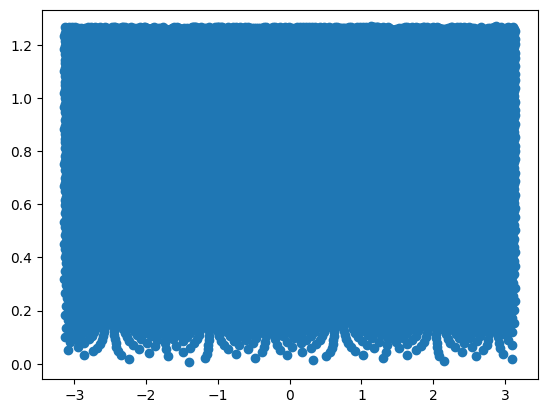

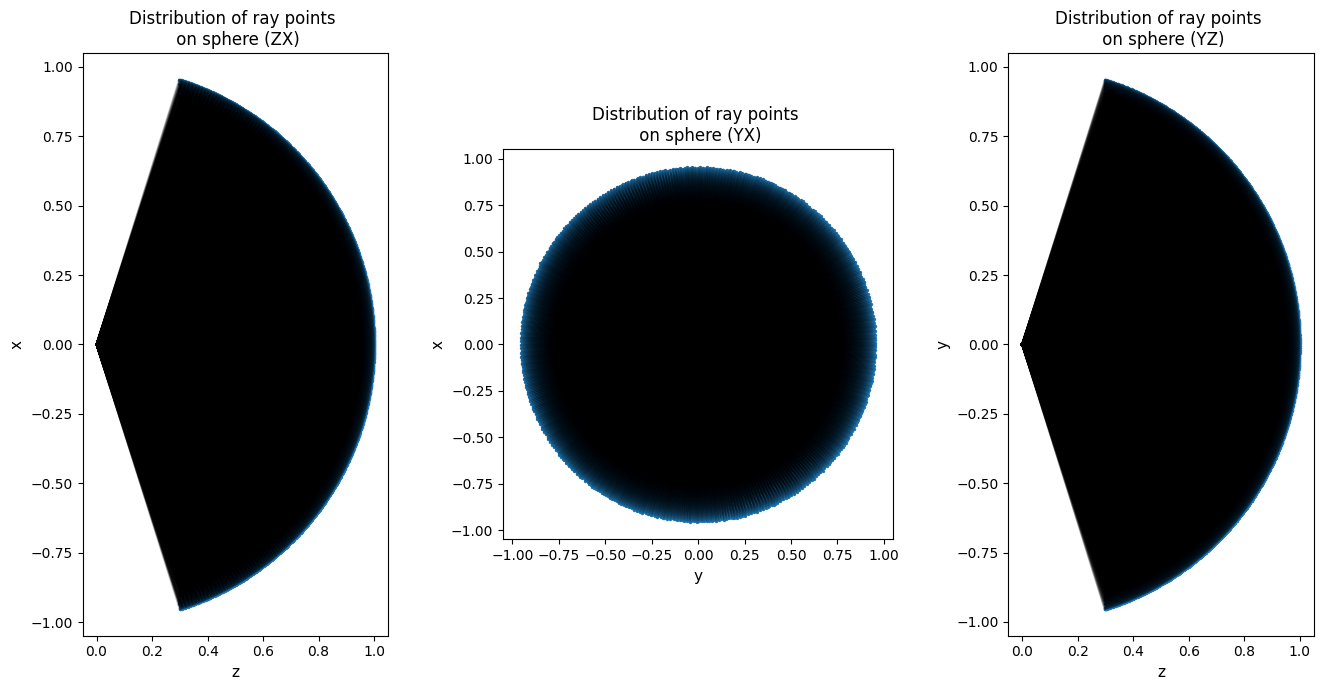

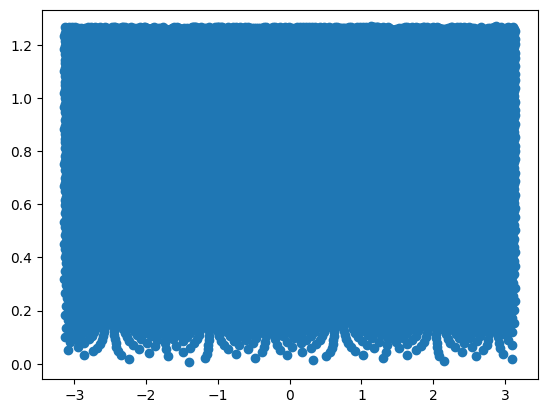

n_dipoles 7499
n_rays 17578
pvec shape (7499, 1, 3)
nvec shape (1, 17578, 3)
(7499, 17578, 3, 1)
(7499, 1, 1, 1)
initial energy shape ()


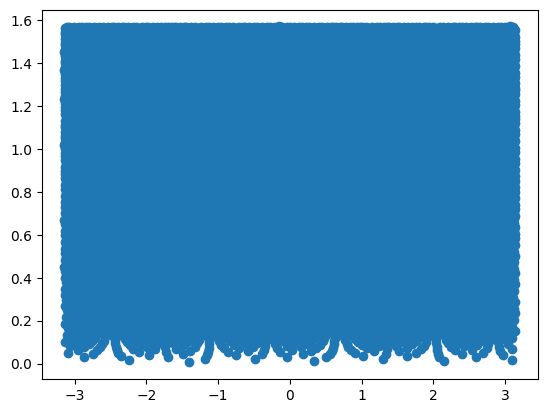

n_dipoles 7499
n_rays 24998
pvec shape (7499, 1, 3)
nvec shape (1, 24998, 3)
(7499, 24998, 3, 1)
(7499, 1, 1, 1)
initial energy shape ()
n rays 2pi =  24998
(17578, 3, 1)
n rays =  17578
NA area vs real area? 4.4172760189146585 4.4172760189146585
half_sphere_energy 4.188790212857002
initial_energy 2.9448870820504855
rays when NA scaled up to hemisphere 25003.153721134167
initialisation time in system 117.617778s
Flat pupil
ELEMENT: <opmsim.optical_elements.SineLens object at 0x0000023BF4A4C250>
CURVED REFRACTION
max rho curved 0.003182955650886398
ELEMENT: <opmsim.optical_elements.SineLens object at 0x0000023BF38A8550>
max rho flat 0.0042333310156789095
FLAT REFRACTION
ELEMENT: <opmsim.optical_elements.SineLens object at 0x0000023BF38C9D90>
CURVED REFRACTION
max rho curved -1.989027789200285e-05
ELEMENT: <opmsim.optical_elements.SineLens object at 0x0000023BF4A4CA60>
max rho flat -1.989027789200285e-05
FLAT REFRACTION
ELEMENT: <opmsim.optical_elements.SineLens object at 0x0000023BF39A1

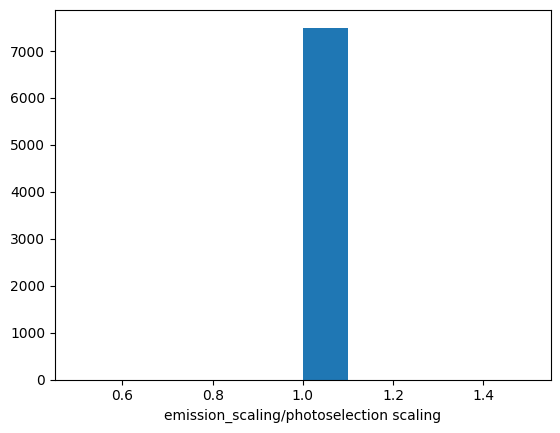

Limiting radius for detector: 0.004233333333333334
Energy ratio (efficiency): 0.4816926847246463
Total energy per dipole per ray: 1.4185305647638282
Energy from Ix 2822.4324844671823
Energy from Iy 2822.4333017431118
X/Y energy ratio = 0.9999997104356978
Half sphere energy 4.188790212857002
Initial energy 2.9448870820504855
half sphere energy NA 2.9448506849503313
maxr 0.004233333333333334
9111 escaped out of 17578
[0.0002513 0.0002513 0.0002513 ... 0.0002513 0.0002513 0.0002513]
Saved checkpoint with 1000 rays
[0.0002513 0.0002513 0.0002513 ... 0.0002513 0.0002513 0.0002513]
9111 escaped out of 17578
time in trace_rays 125.095184s
ray count 8467
max Ix 9.619673789247573
scale range in _plot_unstructured [0, 7, 5]
min for scale 0
max for scale 7
Filling background of polar plot with zeroes!
max_r_in 0 max_r 0.003376967471790459
max_r_reduced 0.003376728771894472 max_r 0.003376967471790459


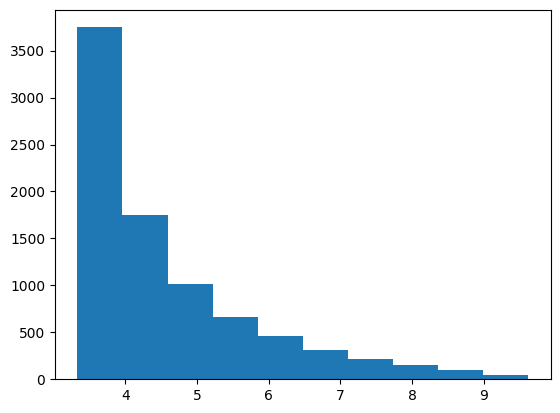

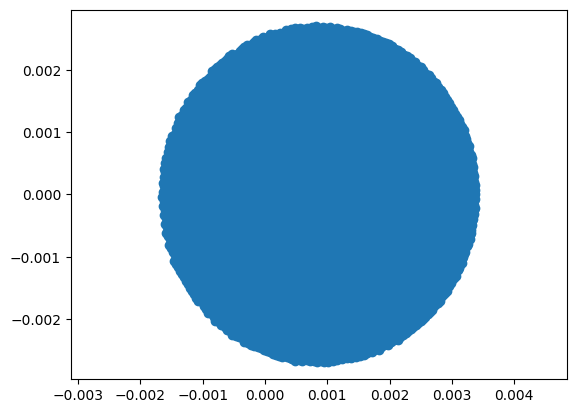

max_r_in None max_r 0.003376967471790459
cb3.vmax bf 19.200000000000003


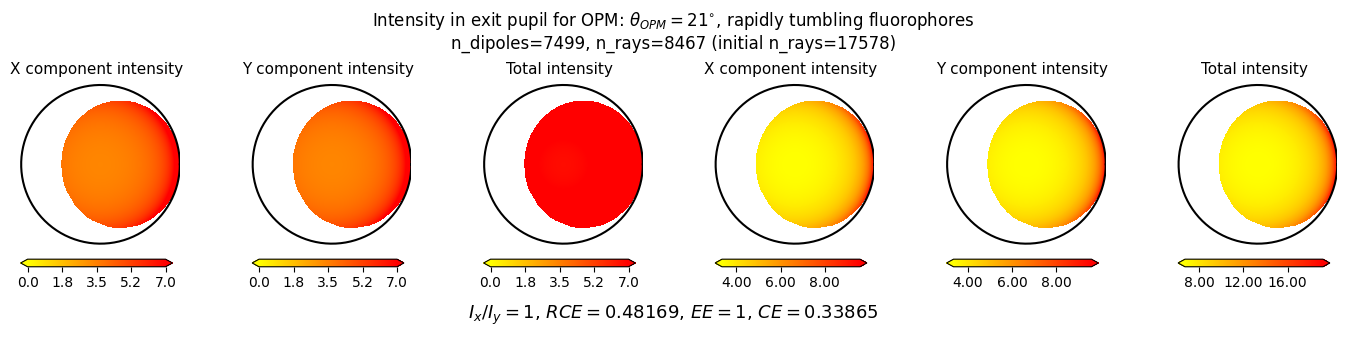

ray count 8467
max Ix 3.3335473877951642
scale range in _plot_unstructured [0, 7, 5]
min for scale 0
max for scale 7
Filling background of polar plot with zeroes!
max_r_in 0 max_r 0.7492749854997101
max_r_reduced 0.7492712118069561 max_r 0.7492749854997101


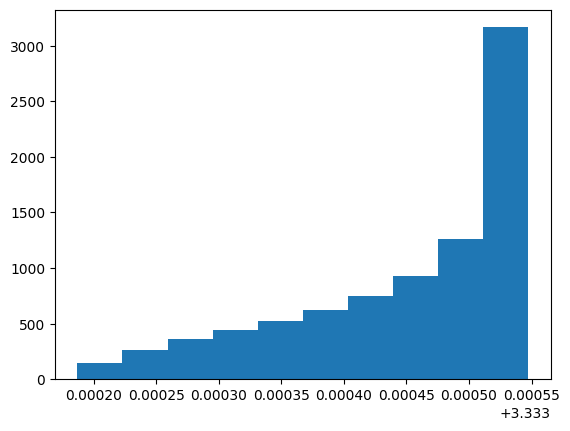

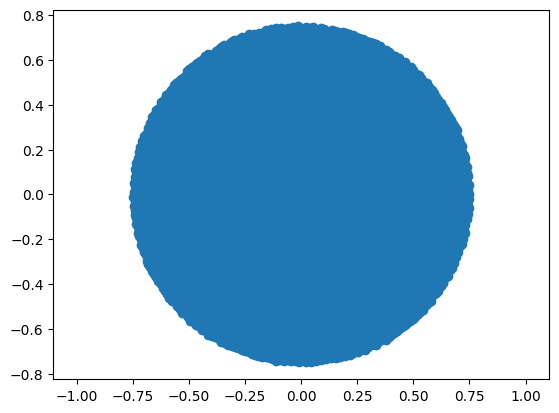

max_r_in None max_r 0.7492749854997101
cb3.vmax bf 6.6670945


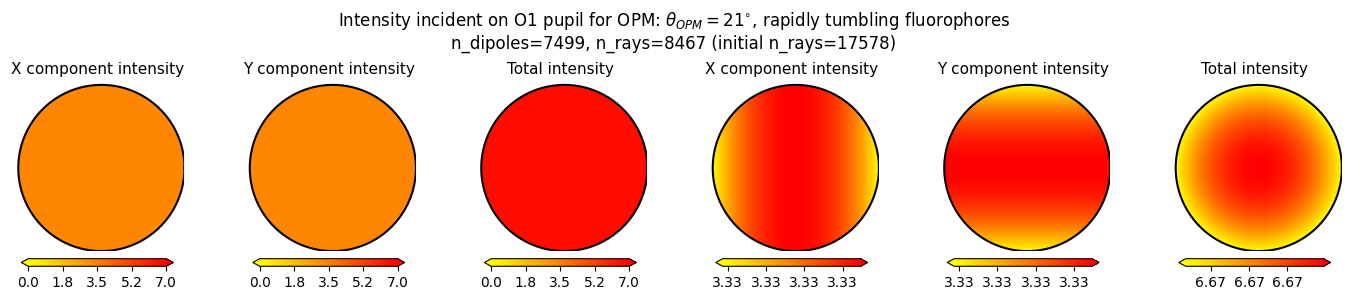

Full sphere generation
cap method area sum 12.564694874875116
expected area sum 6.283185307179586
plot exc arrow


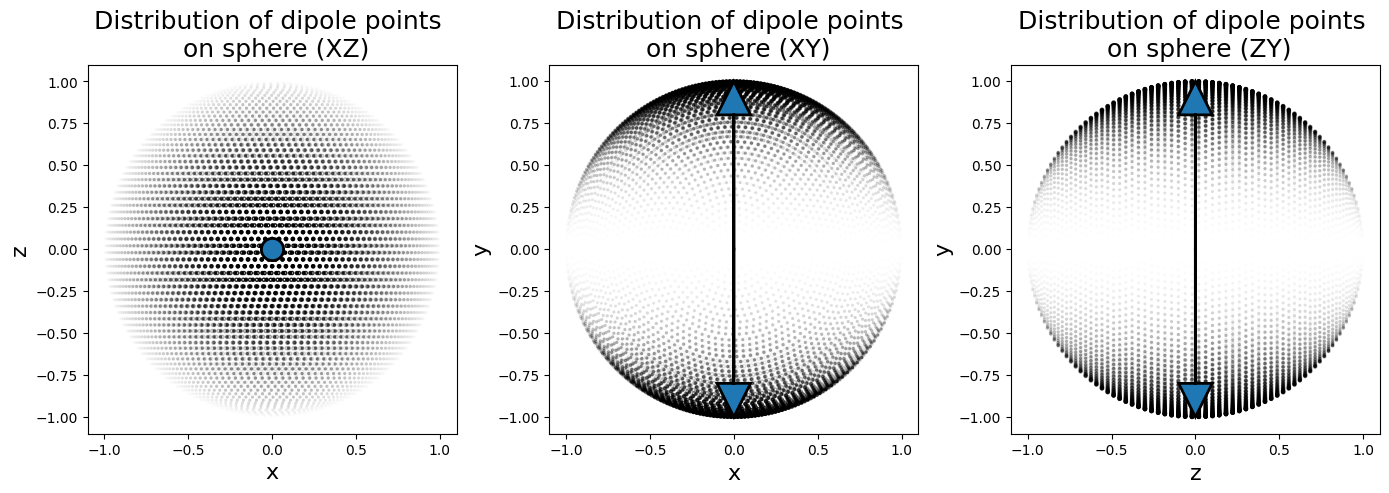

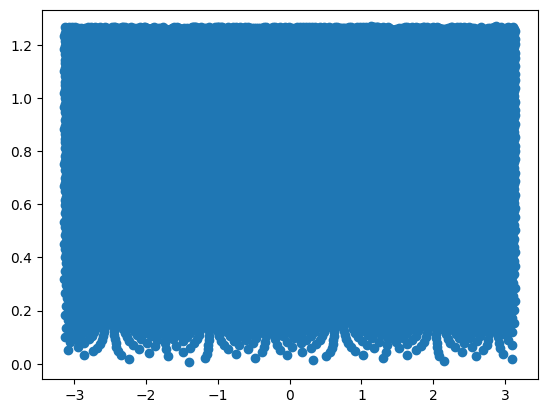

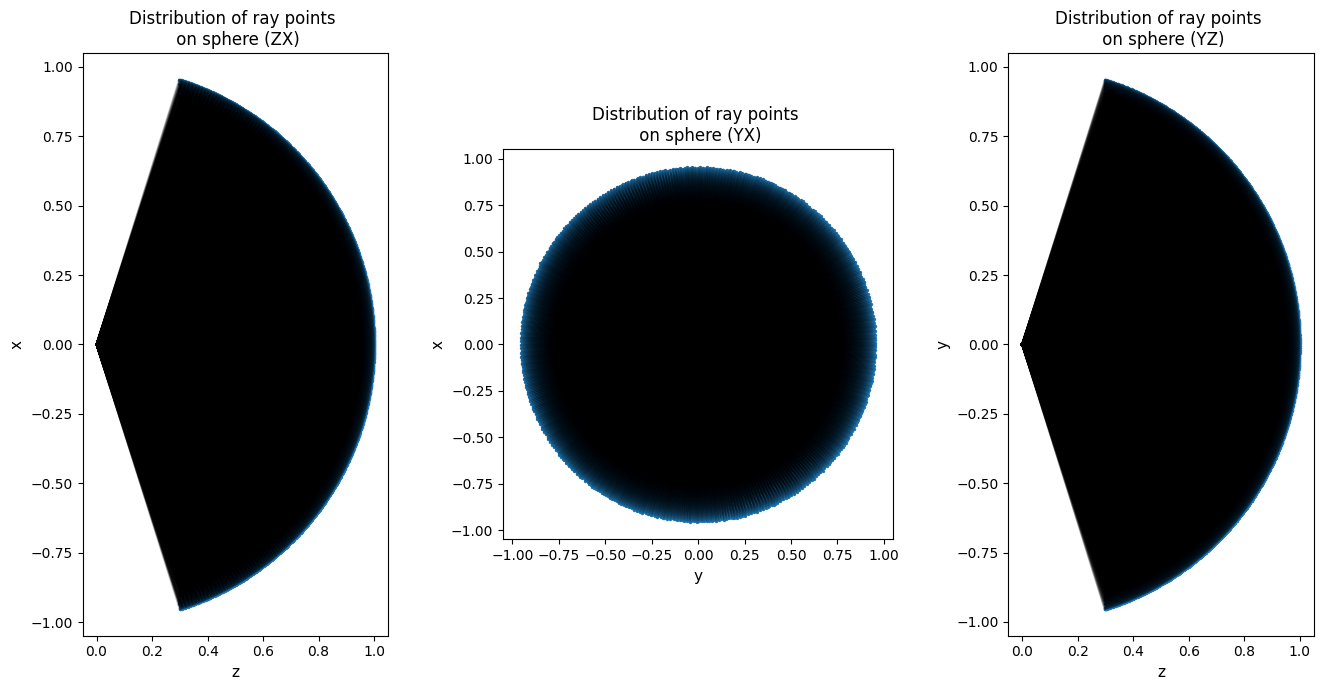

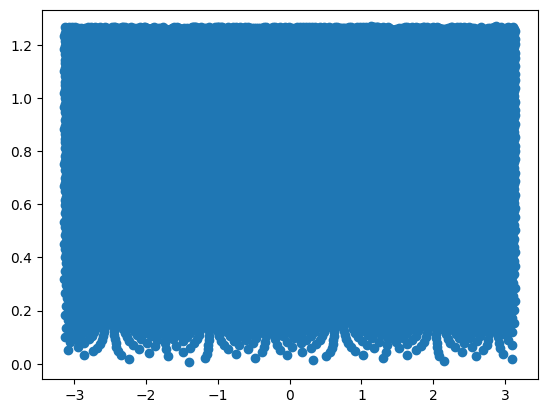

n_dipoles 7499
n_rays 17578
pvec shape (7499, 1, 3)
nvec shape (1, 17578, 3)
(7499, 17578, 3, 1)
(7499, 1, 1, 1)
initial energy shape ()


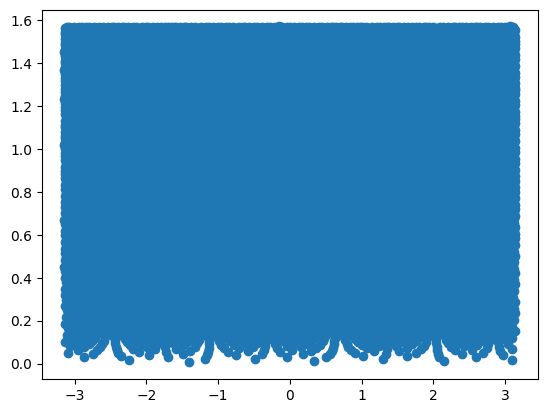

n_dipoles 7499
n_rays 24998
pvec shape (7499, 1, 3)
nvec shape (1, 24998, 3)
(7499, 24998, 3, 1)
(7499, 1, 1, 1)
initial energy shape ()
n rays 2pi =  24998
(17578, 3, 1)
n rays =  17578
NA area vs real area? 4.4172760189146585 4.4172760189146585
half_sphere_energy 1.397012206990809
initial_energy 1.0199068412261012
rays when NA scaled up to hemisphere 25003.153721134167
initialisation time in system 117.167196s
Flat pupil
ELEMENT: <opmsim.optical_elements.SineLens object at 0x0000023BF4A4C250>
CURVED REFRACTION
max rho curved 0.003182955650886398
ELEMENT: <opmsim.optical_elements.SineLens object at 0x0000023BF38A8550>
max rho flat 0.0042333310156789095
FLAT REFRACTION
ELEMENT: <opmsim.optical_elements.SineLens object at 0x0000023BF38C9D90>
CURVED REFRACTION
max rho curved -1.989027789200285e-05
ELEMENT: <opmsim.optical_elements.SineLens object at 0x0000023BF4A4CA60>
max rho flat -1.989027789200285e-05
FLAT REFRACTION
ELEMENT: <opmsim.optical_elements.SineLens object at 0x0000023C03129

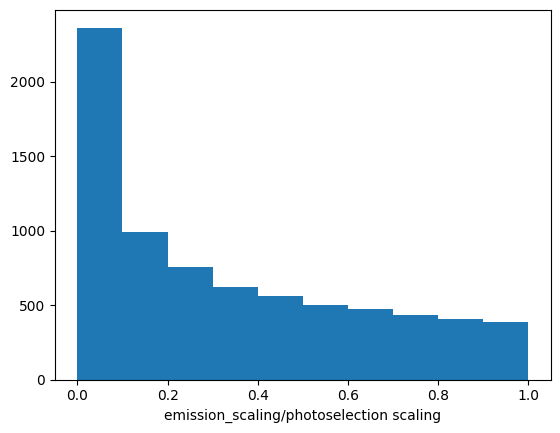

Limiting radius for detector: 0.004233333333333334
Energy ratio (efficiency): 0.5148045971048776
Total energy per dipole per ray: 0.5250527304819114
Energy from Ix 575.6768622633373
Energy from Iy 1513.7051136175203
X/Y energy ratio = 0.38030978232448387
Half sphere energy 1.397012206990809
Initial energy 1.0199068412261012
half sphere energy NA 0.9821433267327256
maxr 0.004233333333333334
9111 escaped out of 17578
[0.0002513 0.0002513 0.0002513 ... 0.0002513 0.0002513 0.0002513]
Saved checkpoint with 1000 rays
[0.0002513 0.0002513 0.0002513 ... 0.0002513 0.0002513 0.0002513]
9111 escaped out of 17578
time in trace_rays 124.060618s
ray count 8467
max Ix 1.9464352139234153
scale range in _plot_unstructured [0, 7, 5]
min for scale 0
max for scale 7
Filling background of polar plot with zeroes!
max_r_in 0 max_r 0.003376967471790459
max_r_reduced 0.003376728771894472 max_r 0.003376967471790459


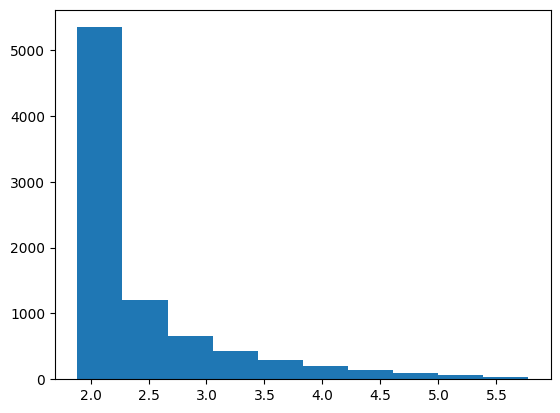

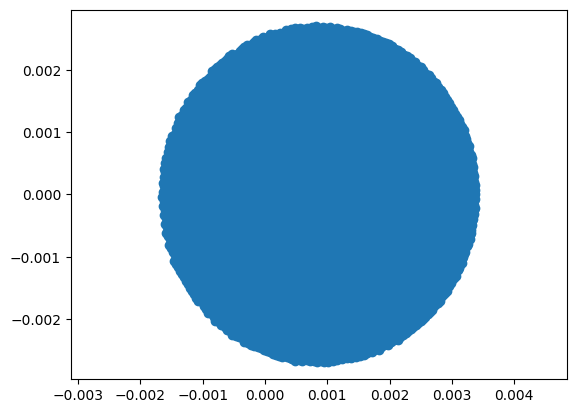

max_r_in None max_r 0.003376967471790459
cb3.vmax bf 7.680000000000001


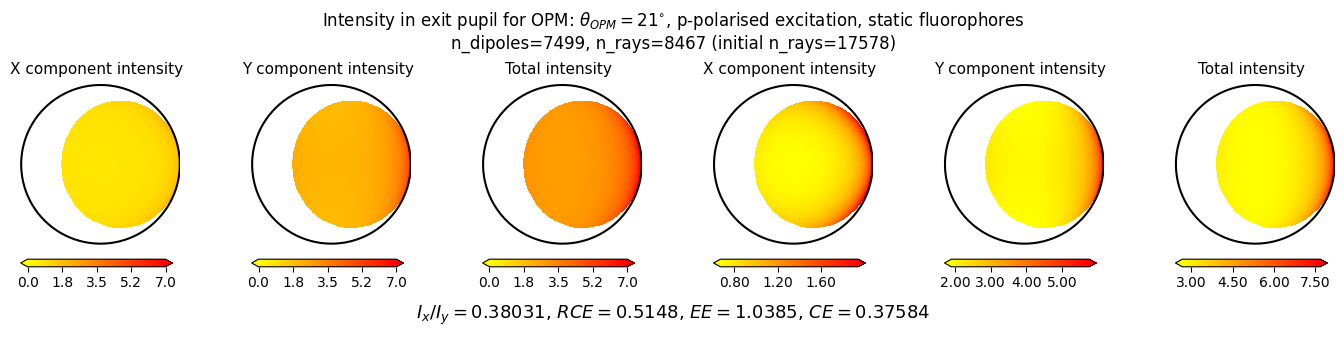

ray count 8467
max Ix 0.7050157817375586
scale range in _plot_unstructured [0, 7, 5]
min for scale 0
max for scale 7
Filling background of polar plot with zeroes!
max_r_in 0 max_r 0.7492749854997101
max_r_reduced 0.7492712118069561 max_r 0.7492749854997101


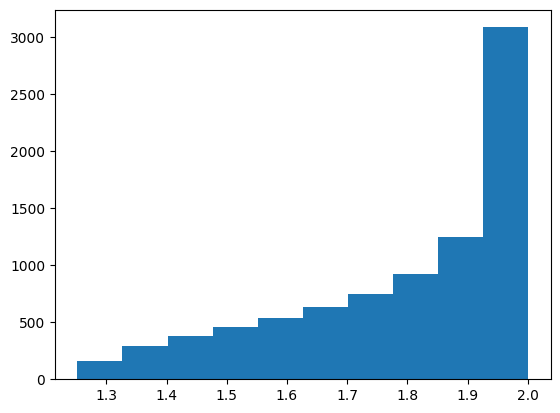

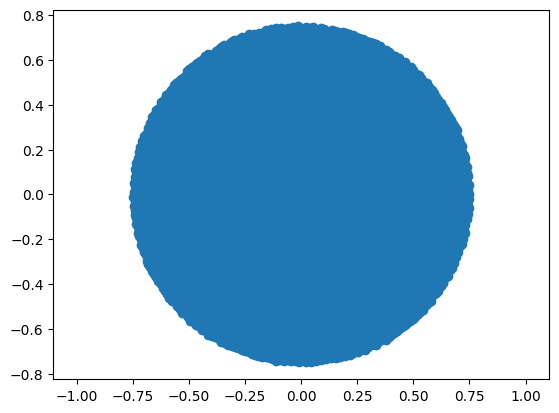

max_r_in None max_r 0.7492749854997101
cb3.vmax bf 2.667


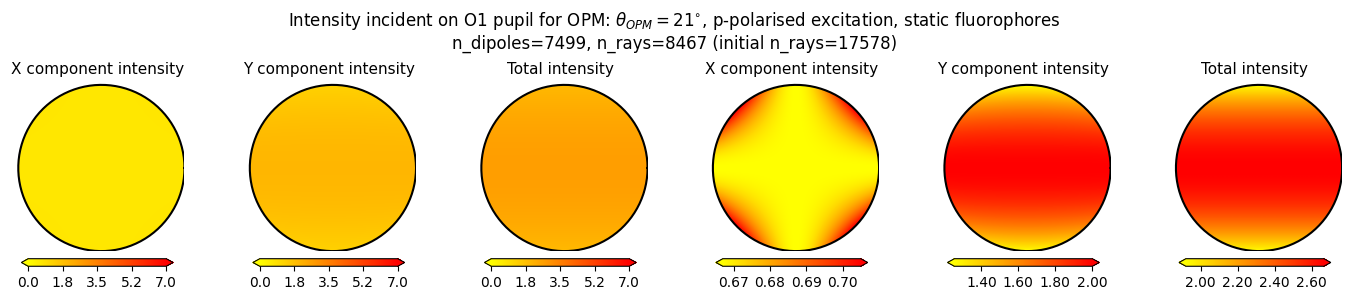

Full sphere generation
cap method area sum 12.564694874875116
expected area sum 6.283185307179586
plot exc arrow


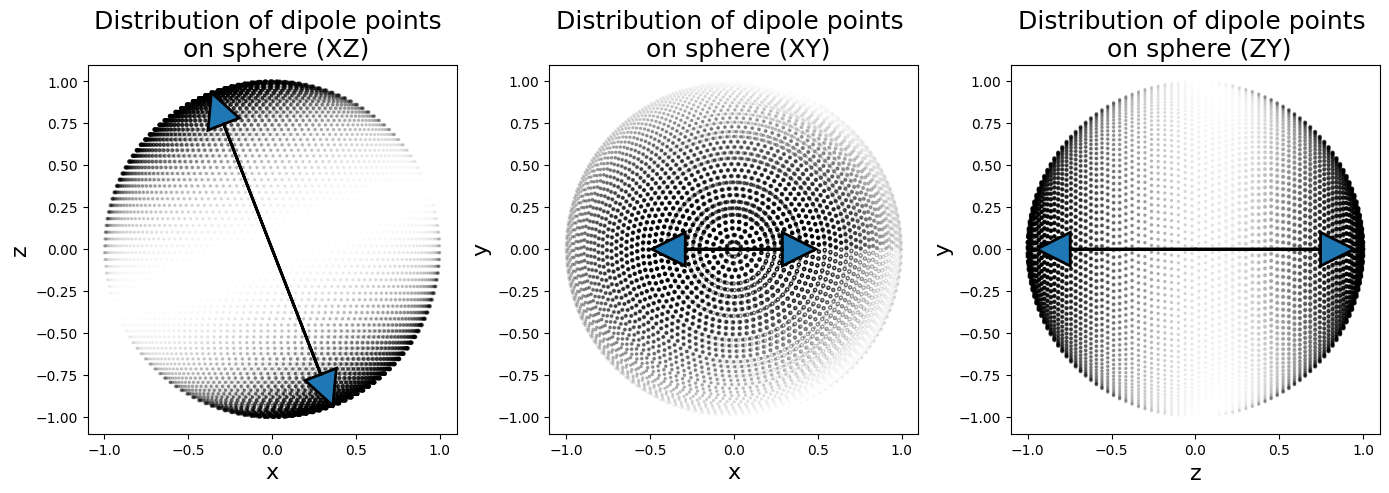

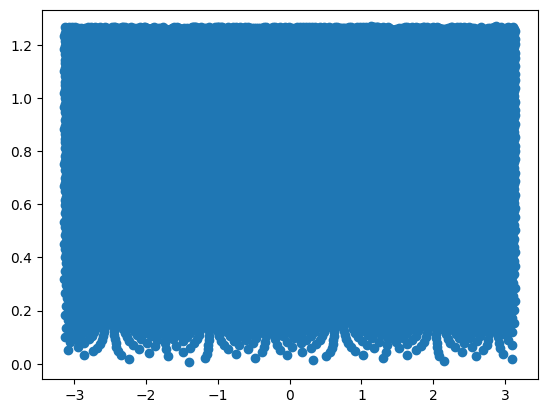

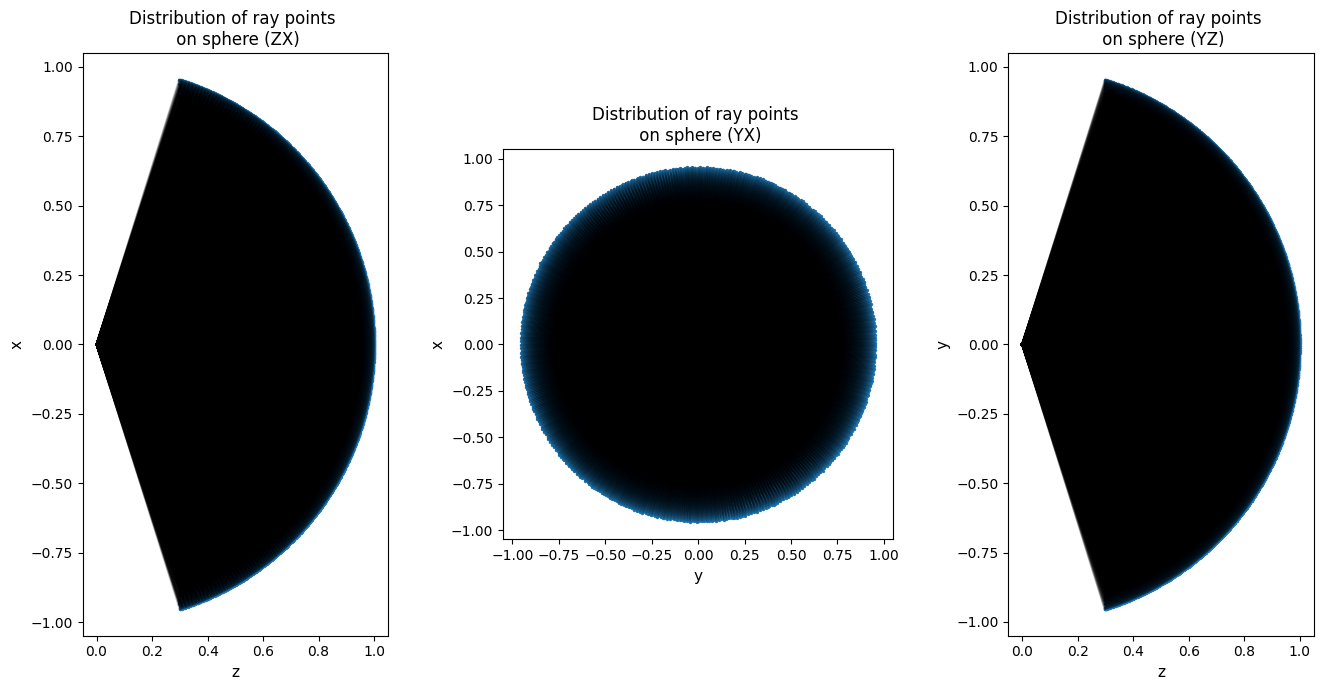

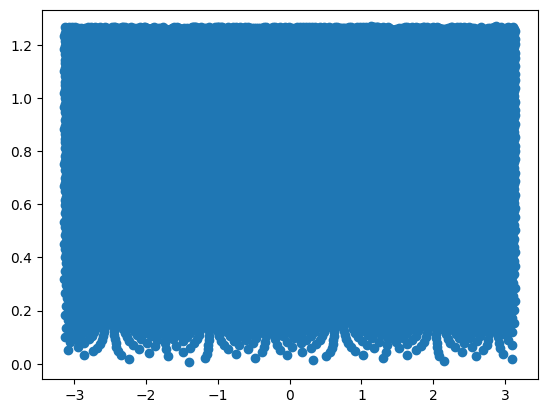

n_dipoles 7499
n_rays 17578
pvec shape (7499, 1, 3)
nvec shape (1, 17578, 3)
(7499, 17578, 3, 1)
(7499, 1, 1, 1)
initial energy shape ()


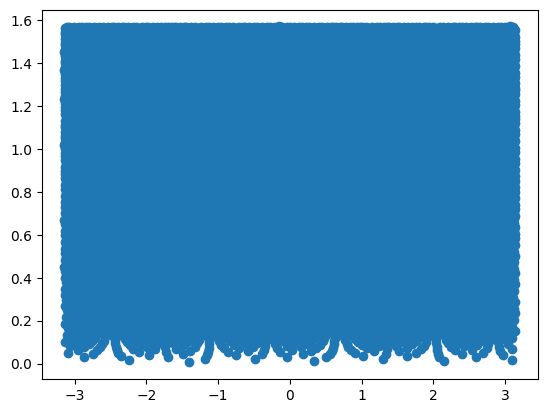

n_dipoles 7499
n_rays 24998
pvec shape (7499, 1, 3)
nvec shape (1, 24998, 3)
(7499, 24998, 3, 1)
(7499, 1, 1, 1)
initial energy shape ()
n rays 2pi =  24998
(17578, 3, 1)
n rays =  17578
NA area vs real area? 4.4172760189146585 4.4172760189146585
half_sphere_energy 1.396101789421433
initial_energy 0.9207951623403037
rays when NA scaled up to hemisphere 25003.153721134167
initialisation time in system 111.233912s
Flat pupil
ELEMENT: <opmsim.optical_elements.SineLens object at 0x0000023BF4A4C250>
CURVED REFRACTION
max rho curved 0.003182955650886398
ELEMENT: <opmsim.optical_elements.SineLens object at 0x0000023BF38A8550>
max rho flat 0.0042333310156789095
FLAT REFRACTION
ELEMENT: <opmsim.optical_elements.SineLens object at 0x0000023BF38C9D90>
CURVED REFRACTION
max rho curved -1.989027789200285e-05
ELEMENT: <opmsim.optical_elements.SineLens object at 0x0000023BF4A4CA60>
max rho flat -1.989027789200285e-05
FLAT REFRACTION
ELEMENT: <opmsim.optical_elements.SineLens object at 0x0000023BAE74C

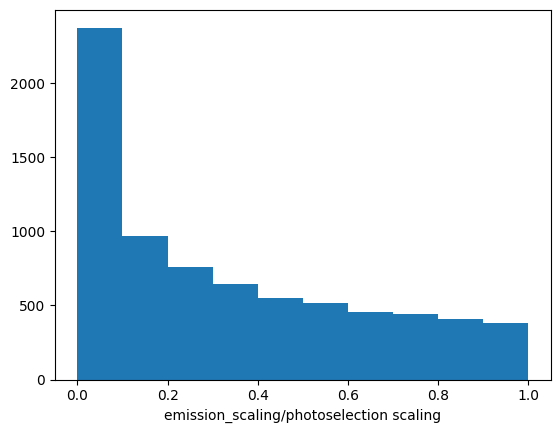

Limiting radius for detector: 0.004233333333333334
Energy ratio (efficiency): 0.42275120748377404
Total energy per dipole per ray: 0.3892672667245811
Energy from Ix 815.0631829560934
Energy from Iy 733.977444160055
X/Y energy ratio = 1.1104744286642634
Half sphere energy 1.396101789421433
Initial energy 0.9207951623403037
half sphere energy NA 0.9815032746731743
maxr 0.004233333333333334
9111 escaped out of 17578
[0.0002513 0.0002513 0.0002513 ... 0.0002513 0.0002513 0.0002513]
Saved checkpoint with 1000 rays
[0.0002513 0.0002513 0.0002513 ... 0.0002513 0.0002513 0.0002513]
9111 escaped out of 17578
time in trace_rays 128.069525s
ray count 8467
max Ix 5.309469616859631
scale range in _plot_unstructured [0, 7, 5]
min for scale 0
max for scale 7
Filling background of polar plot with zeroes!
max_r_in 0 max_r 0.003376967471790459
max_r_reduced 0.003376728771894472 max_r 0.003376967471790459


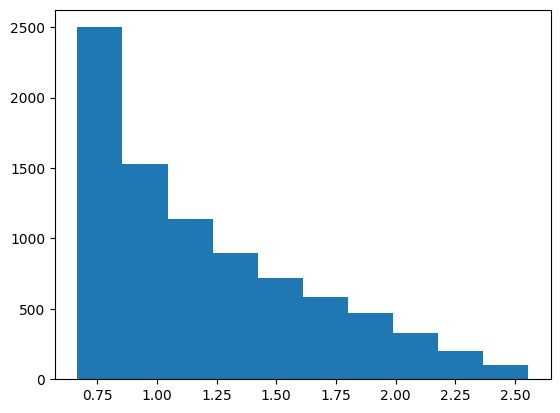

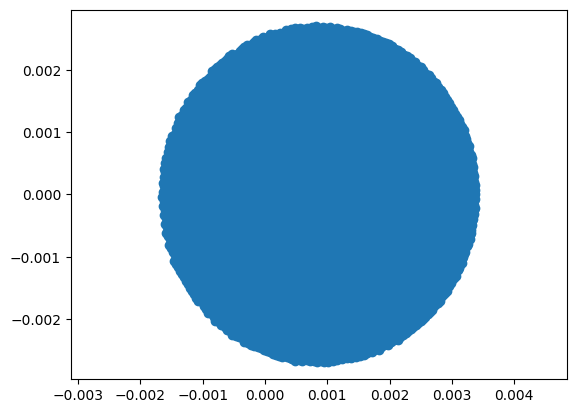

max_r_in None max_r 0.003376967471790459
cb3.vmax bf 7.2250000000000005


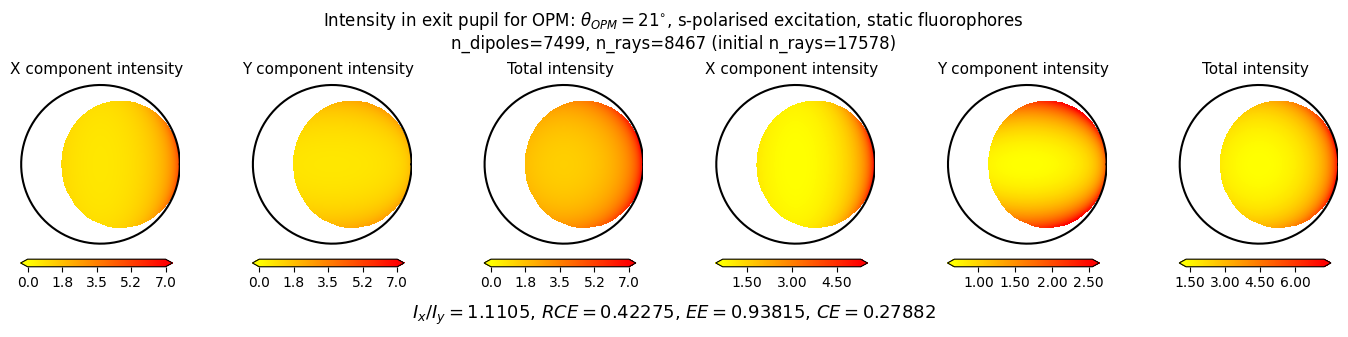

ray count 8467
max Ix 1.8397193202163473
scale range in _plot_unstructured [0, 7, 5]
min for scale 0
max for scale 7
Filling background of polar plot with zeroes!
max_r_in 0 max_r 0.7492749854997101
max_r_reduced 0.7492712118069561 max_r 0.7492749854997101


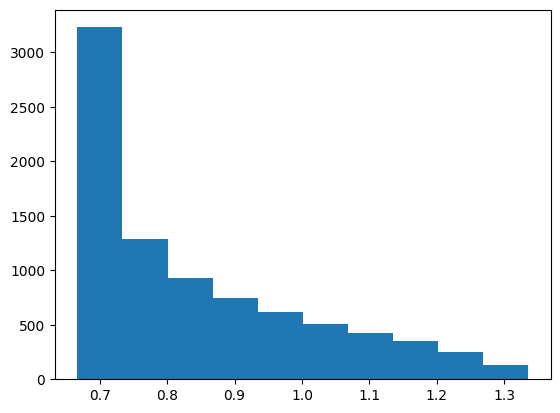

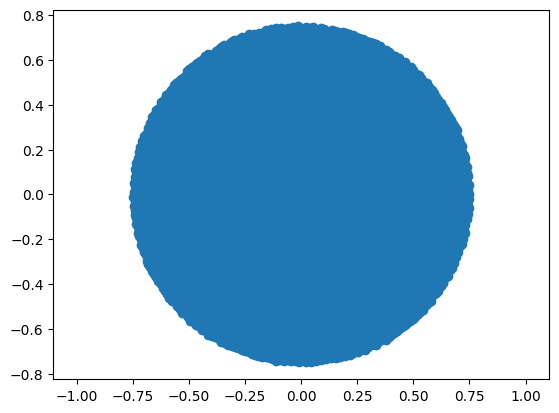

max_r_in None max_r 0.7492749854997101
cb3.vmax bf 2.505


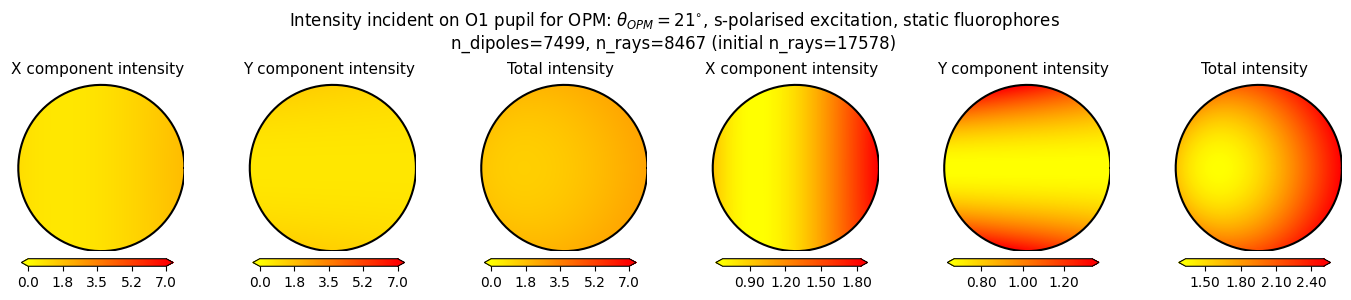

In [11]:
with open(save_details, 'a') as f:
    f.write("focal lengths:\n")
    f.write("O1,TL1,TL2,O2,O3\n")
    fs=[el.focal_length for el in elements_fun(0)]
    f.write(",".join(str(item) for item in fs))
    f.write("\noptions:\n")
    f.write(json.dumps(options))
    f.write("\nmin_OPM_angle: %f\n" % min_OPM_angle )
    f.write("\nOPM_angle_noclip: %f\n" % OPM_angle_noclip )
    
with open(save_filename, 'a') as f:
    f.write("angle,polarisation,NA1,NA2,NA3,RCE,EE,CE\n")
    for opm_angle in opm_angles:
        # un/depolarised
        source = dipole_source.DipoleSource()
        # source.add_dipoles((0,0))
        source.generate_dipoles(dipole_count)

        system = OpticalSystem("OPM (%d degrees) rapid tumbling" % opm_angle, elements_fun(opm_angle), source, options)
        system.trace()
        plot_options['title'] = \
            r'Intensity in exit pupil for OPM: $\theta_{OPM}=%d^{\circ}$, rapidly tumbling fluorophores' \
            % (opm_angle)
        pupil_fig = system.detector.plot_pupil(**plot_options_un)
        pupil_fig.savefig(os.path.join(savepath_full, "pupil_plot_tumbling_%d.png" % (opm_angle)), bbox_inches='tight' )

        f.write("%0.4f,%s, %.2f,%.2f,%.2f,%0.5f,%0.5f,%0.5f\n" % 
            (opm_angle, "unpolarised", elements_fun(opm_angle)[0].NA, elements_fun(opm_angle)[3].NA, elements_fun(opm_angle)[4].NA,
             system.detector.relative_collection_efficiency,
             system.detector.emission_efficiency, 
             system.detector.collection_efficiency)
            )

        plot_options['title'] = \
            r'Intensity incident on O1 pupil for OPM: $\theta_{OPM}=%d^{\circ}$, rapidly tumbling fluorophores'\
            % (opm_angle)
        pupil_fig_i = system.initial_detector.plot_pupil(**plot_options_un)
        pupil_fig_i.savefig(os.path.join(savepath_full, "initial_pupil_plot_tumbling_%d.png" % (opm_angle)), bbox_inches='tight' )

        # p-polarised 
        source = dipole_source.DipoleSource()
        source.generate_dipoles(dipole_count)
        source.classical_photoselection(p_pol)

        system = OpticalSystem("OPM system (%d degrees) p-polarised" % opm_angle, elements_fun(opm_angle), source, options)
        system.trace()
        plot_options['title'] = \
            r'Intensity in exit pupil for OPM: $\theta_{OPM}=%d^{\circ}$, p-polarised excitation, static fluorophores'\
            % (opm_angle)
        pupil_fig = system.detector.plot_pupil(**plot_options_p)
        pupil_fig.savefig(os.path.join(savepath_full, "pupil_plot_p-polarised_%d.png" % (opm_angle)), bbox_inches='tight' )

        f.write("%0.4f,%s, %.2f,%.2f,%.2f,%0.5f,%0.5f,%0.5f\n" % 
            (opm_angle, "p-polarised", elements_fun(opm_angle)[0].NA, elements_fun(opm_angle)[3].NA, elements_fun(opm_angle)[4].NA,
             system.detector.relative_collection_efficiency,
             system.detector.emission_efficiency, 
             system.detector.collection_efficiency)
            )

        plot_options['title'] = \
            r'Intensity incident on O1 pupil for OPM: $\theta_{OPM}=%d^{\circ}$, p-polarised excitation, static fluorophores'\
            % (opm_angle)
        pupil_fig_i = system.initial_detector.plot_pupil(**plot_options_p)
        pupil_fig_i.savefig(os.path.join(savepath_full, "initial_pupil_plot_p-polarised_%d.png" % (opm_angle)), bbox_inches='tight')

        # s-polarised
        source = dipole_source.DipoleSource()
        source.generate_dipoles(dipole_count)
        source.classical_photoselection(s_pol(opm_angle))

        system = OpticalSystem("OPM system (%d degrees) s-polarised" % opm_angle, elements_fun(opm_angle), source, options)
        system.trace()
        plot_options['title'] = \
            r'Intensity in exit pupil for OPM: $\theta_{OPM}=%d^{\circ}$, s-polarised excitation, static fluorophores'\
            % (opm_angle)
        pupil_fig = system.detector.plot_pupil(**plot_options_s)
        pupil_fig.savefig(os.path.join(savepath_full, "pupil_plot_s-polarised_%d.png" % (opm_angle)), bbox_inches='tight' )

        f.write("%0.4f,%s, %.2f,%.2f,%.2f,%0.5f,%0.5f,%0.5f\n" % 
            (opm_angle, "s-polarised", elements_fun(opm_angle)[0].NA, elements_fun(opm_angle)[3].NA, elements_fun(opm_angle)[4].NA,
             system.detector.relative_collection_efficiency,
             system.detector.emission_efficiency, 
             system.detector.collection_efficiency)
            )

        plot_options['title'] = \
            r'Intensity incident on O1 pupil for OPM: $\theta_{OPM}=%d^{\circ}$, s-polarised excitation, static fluorophores'\
            % (opm_angle)
        pupil_fig_i = system.initial_detector.plot_pupil(**plot_options_s)
        pupil_fig_i.savefig(os.path.join(savepath_full, "initial_pupil_plot_s-polarised_%d.png" % (opm_angle)), bbox_inches='tight' )



In [32]:
import json
fs=[el.focal_length for el in elements_fun(0)]
(",".join(str(item) for item in fs))


'0.003,0.18,0.162,0.0036,0.004'

In [5]:
opm_angles

[0, 35, 45, 25.54383661122486, 15.865785498045994]